# 项目：数据探索——洞察病人挂号预约但未前往就诊的原因

## 目录
<ul>
<li><a href="#intro">项目背景</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 项目背景
> 发展中国家的医疗资源通常都是稀缺的。预约就诊但实际未前往就诊会占用他人的就医机会。该项目中，我们需要了解病人的预约就诊情况，并探索那些没有及时就诊的病人可能的原因，包括：
><ol>
    <li>年龄是否会影响就诊率？是否年纪越大就诊率越高？
    <li>预约就诊日期与预约日期之间的间隔分布是什么样的？是否间隔越近就诊率越高？</li>
    <li>短信通知是否提高了就诊率？</li>
    <li>哪些因素可能对决定就诊的影响最大？</li>
</ol>

> 该项目使用的数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关病人特点的多个数值，包括：
> <ul>
    <li>Gender：病人性别；</li>
    <li>Age：病人年龄；</li>
    <li>ScheduledDay：预约日期，指病人具体预约就诊的日期；</li>
    <li>AppointmentDay：预约就诊日期，指病人计划就诊的日期；</li>
    <li>Neighborhood：街区，指医院所在位置；</li>
    <li>Scholarship：福利保障，说明病人是否是巴西福利项目 Bolsa Família 的保障人群。0表示“否”，1表示“是”；</li>
    <li>Hipertension：是否有高血压。0表示“否”，1表示“是”；</li>
    <li>Diabetes：是否有糖尿病。0表示“否”，1表示“是”；</li>
    <li>Alcoholism：是否酗酒。0表示“否”，1表示“是”；</li>
    <li>Handcap：是否是残障人士。0表示“否”，1-4表示“残障等级”；</li>
    <li>SMS_received：是否收到短信通知。0表示“否”，1表示“是”；</li>
    <li>No-show：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。

>

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from subprocess import call

<a id='wrangling'></a>
## 数据整理


### 常规属性

In [2]:
df = pd.read_csv('KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
df.duplicated().sum()

0

> 经查看前几行数据和数据类型后，发现：
> <ul>
    <li>PatientId：ID是浮点数。通常ID是整数。</li>
    <li>ScheduledDay：字段名包含Day，但是数据却包含时分秒。</li>
    <li>AppointmentDay：字段名包含Day，但是数据却包含时分秒，时分秒前五行数据都是0。</li>
    <li>没有字段存在缺失数据。</li>
    <li>没有重复数据。</li></ul>

In [5]:
for i in df['PatientId'].unique():
    if str(i).split('.')[1] != '0':
        print(i)
        break

93779.52927


> 经检查，PatientId缺失存在浮点数数值。PatientId数据类型是浮点数，是正常的。

### 格式化日期字段

In [6]:
df['AppointmentDay'].unique()

array(['2016-04-29T00:00:00Z', '2016-05-03T00:00:00Z',
       '2016-05-10T00:00:00Z', '2016-05-17T00:00:00Z',
       '2016-05-24T00:00:00Z', '2016-05-31T00:00:00Z',
       '2016-05-02T00:00:00Z', '2016-05-30T00:00:00Z',
       '2016-05-16T00:00:00Z', '2016-05-04T00:00:00Z',
       '2016-05-19T00:00:00Z', '2016-05-12T00:00:00Z',
       '2016-05-06T00:00:00Z', '2016-05-20T00:00:00Z',
       '2016-05-05T00:00:00Z', '2016-05-13T00:00:00Z',
       '2016-05-09T00:00:00Z', '2016-05-25T00:00:00Z',
       '2016-05-11T00:00:00Z', '2016-05-18T00:00:00Z',
       '2016-05-14T00:00:00Z', '2016-06-02T00:00:00Z',
       '2016-06-03T00:00:00Z', '2016-06-06T00:00:00Z',
       '2016-06-07T00:00:00Z', '2016-06-01T00:00:00Z',
       '2016-06-08T00:00:00Z'], dtype=object)

> 经检查，AppointmentDay所有值的时分秒都是0，因此该字段可以舍弃时分秒仅保留年月日。

In [7]:
df['ScheduledTime'] = pd.to_datetime(df['ScheduledDay']).dt.time
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledTime
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,18:38:08
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,16:08:27
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,16:19:04
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,17:29:31
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,16:07:23


### 删除值域异常的数据

In [8]:
(df['ScheduledDay'] > df['AppointmentDay']).sum()

5

In [9]:
df.query('ScheduledDay > AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledTime
27033,7.839273e+12,5679978,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,10:51:53
55226,7.896294e+12,5715660,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,14:50:41
64175,2.425226e+13,5664962,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,13:43:58
71533,9.982316e+14,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,13:49:20
72362,3.787482e+12,5655637,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,06:50:57


> 经检查，存在AppointmentDay早于ScheduledDay的数据。这不符合常理，暂时认为是异常数据。

In [10]:
df = df.drop(index=df.query('ScheduledDay > AppointmentDay').index,axis=0)
df.query('ScheduledDay > AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledTime


In [11]:
df['Age'].unique()

array([ 62,  56,   8,  76,  23,  39,  21,  19,  30,  29,  22,  28,  54,
        15,  50,  40,  46,   4,  13,  65,  45,  51,  32,  12,  61,  38,
        79,  18,  63,  64,  85,  59,  55,  71,  49,  78,  31,  58,  27,
         6,   2,  11,   7,   0,   3,   1,  69,  68,  60,  67,  36,  10,
        35,  20,  26,  34,  33,  16,  42,   5,  47,  17,  41,  44,  37,
        24,  66,  77,  81,  70,  53,  75,  73,  52,  74,  43,  89,  57,
        14,   9,  48,  83,  72,  25,  80,  87,  88,  84,  82,  90,  94,
        86,  91,  98,  92,  96,  93,  95,  97, 102, 115, 100,  99,  -1])

In [12]:
df.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledTime
99832,4.659432e+14,5775010,F,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No,08:58:13


> 经检查，存在Age=-1的数据。由于Gender非空，而鉴定性别在大多数国家都是非法的，通过Google暂时没查到巴西的相关法律法规，暂时认为Age<0是异常数据。

In [13]:
df = df.drop(index=df.query('Age < 0').index,axis=0)
df.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledTime


> 经确认，AppointmentDay和Age异常的数据已经删除。

> 由于项目的关键指标，即应变量是“就诊率”，为了方便后续分析，新增appointment字段，“False”表示“未就诊”，“True”表示“已就诊”。

In [14]:
df['appointment'] = df['No-show'].replace({'Yes':False,'No':True})
df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledTime,appointment
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,18:38:08,True
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,16:08:27,True
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,16:19:04,True
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,17:29:31,True
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,16:07:23,True
5,9.598513e+13,5626772,F,2016-04-27,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,No,08:36:51,True
6,7.336882e+14,5630279,F,2016-04-27,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,Yes,15:05:12,False
7,3.449833e+12,5630575,F,2016-04-27,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,Yes,15:39:58,False
8,5.639473e+13,5638447,F,2016-04-29,2016-04-29,21,ANDORINHAS,0,0,0,0,0,0,No,08:02:16,True
9,7.812456e+13,5629123,F,2016-04-27,2016-04-29,19,CONQUISTA,0,0,0,0,0,0,No,12:48:25,True


<a id='eda'></a>
## 探索性数据分析

###  1. 年龄是否会影响就诊率？
是否年纪越大就诊率越高？

In [15]:
df['Age'].value_counts()

0      3539
1      2273
52     1746
49     1652
53     1651
56     1635
38     1628
59     1624
2      1618
50     1613
57     1603
36     1580
51     1567
19     1544
39     1536
37     1533
54     1530
34     1526
33     1524
30     1521
6      1521
3      1513
17     1509
32     1505
5      1489
44     1487
18     1487
58     1469
46     1460
45     1453
       ... 
72      615
74      602
76      571
75      544
78      541
77      527
80      511
81      433
82      392
79      390
84      311
83      280
85      275
86      260
87      184
89      173
88      126
90      109
92       86
91       66
93       53
94       33
95       24
96       17
97       11
98        6
115       5
100       4
102       2
99        1
Name: Age, Length: 103, dtype: int64

>数据集的年龄值域虽然比较广，但90岁以下样本数均多于100，较为充足。为了避免样本少带来的统计偏差，年龄分析暂时忽略91岁之后的样本。

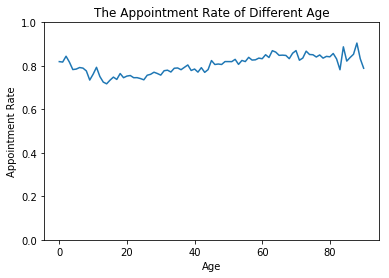

In [16]:
df.query('Age <= 90').groupby('Age')['appointment'].mean().plot(scaley=False);
plt.title('The Appointment Rate of Different Age')
plt.xlabel('Age')
plt.ylabel('Appointment Rate');

> 经统计，婴儿出生后就诊率较高，之后就诊率呈下降趋势。20岁左右起就诊率渐渐上升。

> 由于按年龄统计会导致每个年龄的样本数较少，虽然能看出一些趋势，但统计的就诊率与实际会有偏差。

### 2. 预约就诊日期与预约日期之间的间隔分布是什么样的？
是否间隔越近如约就诊率越高，间隔越久如约就诊率越低？

In [17]:
df['day_diff'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

In [18]:
df['day_diff'].value_counts()

0      38562
2       6725
4       5290
1       5213
7       4906
6       4037
5       3277
14      2913
3       2737
8       2332
21      1861
28      1706
13      1682
9       1605
15      1503
10      1391
20      1187
22      1173
16      1151
12      1115
17      1107
29      1089
19      1044
18      1021
27      1013
11       987
35       963
23       822
34       808
26       731
       ...  
103        5
109        5
111        5
98         5
95         5
112        5
108        5
96         4
102        4
105        4
119        4
92         3
122        3
107        2
115        2
93         2
94         2
97         2
110        2
126        1
125        1
123        1
117        1
139        1
82         1
101        1
132        1
151        1
146        1
127        1
Name: day_diff, Length: 129, dtype: int64

> 预约间隔时间可以看看出巴西的就医习惯与国内有明显差别。
> <ul>
    <li>大约30%左右预约当天。在国内当天只能去排队。</li>
    <li>最长甚至可以预约5个月后就诊。在国内通常只能预约近一个月。</li></ul>
数据集的值域较广，day_diff下很多值的样本数都很少。因此通过分桶来观察。由于0天超过30%，因此把0天作为一个桶，剩下的数据通过25分位数、中位数、75分位数作为边界进行分桶，这样可以使每个桶的样本书较为均匀。

In [19]:
df_daydiff = df.query('day_diff > 0')
day_diff_edge = [0,df_daydiff['day_diff'].min(),df_daydiff['day_diff'].quantile(0.25),df_daydiff['day_diff'].median(),df_daydiff['day_diff'].quantile(0.75),df_daydiff['day_diff'].max()+1]
day_diff_edge

[0, 1, 4.0, 9.0, 22.0, 180]

In [20]:
day_diff_label = ['0', '1-3', '4-8', '9-21', '>22']
df['day_diff_bin'] = pd.cut(df['day_diff'],day_diff_edge,labels=day_diff_label,right=False)
df['day_diff_bin'].value_counts()

0       38562
4-8     19842
>22     18875
9-21    18567
1-3     14675
Name: day_diff_bin, dtype: int64

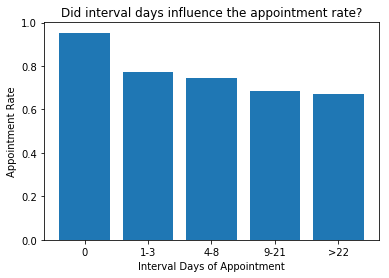

In [21]:
locations_5 = [1,2,3,4,5]
height_day_diff = df.groupby('day_diff_bin')['appointment'].mean().values
plt.bar(locations_5,height_day_diff,tick_label=day_diff_label);
plt.title('Did interval days influence the appointment rate?')
plt.xlabel('Interval Days of Appointment')
plt.ylabel('Appointment Rate');

> 经分析，预约时间和就诊实践越近，就诊率越高。预约当天就诊的就诊率明显高于其他。这是可以理解的，对于刚刚发生的事情，确定性会比较强。而较晚发生的事情，病人可能会忘记，或者病情已经得到好转没有必要再去医院。

### 3. 短信通知是否提高了就诊率？

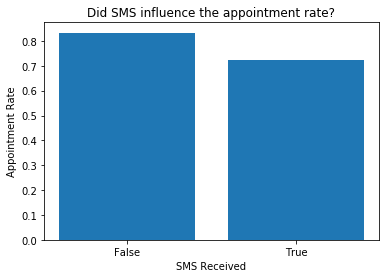

In [22]:
locations_2 = [1,2]
bool_label = [False,True]
sms_height = df.groupby('SMS_received')['appointment'].mean().values
plt.bar(locations_2,sms_height,tick_label=bool_label);
plt.title('Did SMS influence the appointment rate?')
plt.xlabel('SMS Received')
plt.ylabel('Appointment Rate');

> 经分析，没有收到短信的情况下，反而就诊率要比短信提醒要高。这不合常理，短信理论上应该可以提升就诊率才对。结合预约时间间隔来分析下，不同的时间间隔的病人短信提醒对其就诊率的影响。

In [23]:
df.groupby(['day_diff_bin','SMS_received'])['appointment'].count()

day_diff_bin  SMS_received
0             0               38562
1-3           0               13769
              1                 906
4-8           0                7760
              1               12082
9-21          0                7772
              1               10795
>22           0                7176
              1               11699
Name: appointment, dtype: int64

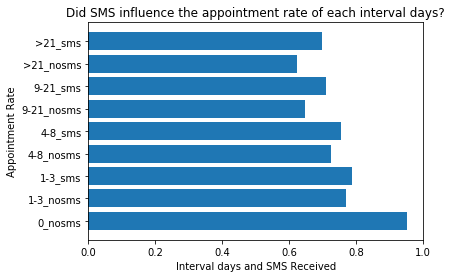

In [24]:
locations_9 = [1,2,3,4,5,6,7,8,9]
ds_label = ['0_nosms','1-3_nosms','1-3_sms','4-8_nosms','4-8_sms','9-21_nosms','9-21_sms','>21_nosms','>21_sms']
ds_height = df.groupby(['day_diff_bin','SMS_received'])['appointment'].mean().values
plt.barh(locations_9,ds_height,tick_label=ds_label);
plt.title('Did SMS influence the appointment rate of each interval days?')
plt.xlabel('Interval days and SMS Received')
plt.ylabel('Appointment Rate');

> 经分析，预约间隔时间在一天以上，收到短信的病人就诊率高于未收到短信的病人，并且时间间隔越长，短信提升的效果越大。

> 问题3中观察到的未收到短信的病人就诊率高是因为预订当天的病人没有收到短信的样本，加上预订当天的就诊率非常高，导致单维度下的统计偏差。由于3天以下间隔收到短信的样本太少，3天以下间隔短信的作用还有待扩充样本进一步分析。

### 4. 哪些因素可能对决定就诊的影响最大？
> apointment（是否就诊），只会有两种结果，就诊和未就诊。由于不是一个线性的变量，因此尝试用逻辑回归来寻找出已有的特征中，对是否就诊影响最大的因素。

In [25]:
df = df.join(pd.get_dummies(df['Gender']))
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledTime,appointment,day_diff,day_diff_bin,F,M
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,18:38:08,True,0,0,1,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,16:08:27,True,0,0,0,1
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,16:19:04,True,0,0,1,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,17:29:31,True,0,0,1,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,16:07:23,True,0,0,1,0


In [26]:
df['interception'] = 1
logit_model = sm.Logit(df['appointment'], df[['interception', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'M']])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.492978
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            appointment   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110512
Method:                           MLE   Df Model:                            8
Date:                Fri, 08 Mar 2019   Pseudo R-squ.:                 0.01997
Time:                        10:03:33   Log-Likelihood:                -54484.
converged:                       True   LL-Null:                       -55595.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
interception     1.3846      0.018     78.729      0.000       1.350       1.419
Age              0.0066      0.000     16.745      0.000       0.006       0.007
Scholarship     -0.1846      0.025     -7.532      0.000      -0.233      -0.137
Hipertension     0.0675      0.025      2.747      0.006       0.019       0.116
Diabetes        -0.0853      0.034     -2.500      0.012      -0.152      -0.018
Alcoholism      -0.1403      0.045     -3.132      0.002      -0.228      -0.053
Handcap         -0.0284      0.049     -0.585      0.559      -0.124       0.067
SMS_received    -0.6503      0.015    -42.030      0.000      -0.681      -0.620
M                0.0182      0.016      1.120      0.263      -0.014       0.050
================================================================================
"""

> 经分析，数据集中除了残障等级和性别以外，其他特征有统计显著性。对就诊率影响最大的3个特征分别是：是否收到短信、是否参与社会福利项目以及是否酗酒。相对而言，其他的特征对结果的影响都非常小。这个结果不太符合常识，因为通常我们会认为疾病本身的严重性是一个比较强的特征。为了确认这些特征是否足以预测结果，将80%的数据集作为训练集，20%数据集作为测试集来计算一下预测的准确度。

In [27]:
X = df[['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'M']]
y = df['appointment']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [28]:
lm = LogisticRegression().fit(X_train,y_train)
y_predict = lm.predict(X_test)
print(precision_score(y_test,y_predict))
print(recall_score(y_test,y_predict))
print(accuracy_score(y_test,y_predict))

0.796516625197919
1.0
0.796516625197919


> 召回率和准确率分别达到了100%和76%，还是有相当比例的预测错误，将未就诊的病人预测为就诊。在数据集的特征之外，应该还有其他重要的特征存在。

> 由于样本量小，可供测试的数据并不丰富，暂时没有办法得出可靠的结论。

<a id='conclusions'></a>
## 结论

> 经过对数据的探索，我们发现：
><ol>
    <li>年龄越大就诊率越高。年龄越大通常身体状况越差，就医的诉求也约迫切，就诊率高符合常规的认知。虽然可以看到趋势，但由于分摊到每个年龄后样本较少，因此实际每个年龄的就诊率统计结果与实际会存在偏差。</li>
    <li>大约30%左右的预约，是预约当天就诊。少部分人甚至预约5个月后就诊。这与国内的情况差异很大，在国内当天只能去医院排队，也难以预约几个月后就诊。</li>
    <li>预约时间和就诊时间越接近，就诊率越高。预约当天就诊的就诊率明显高于其他。</li>
    <li>短信提醒对提升就诊率有帮助，尤其是对于预约间隔比较久的病人。由于3天以下收到短信的病人样本不足，短信对3天以下预约间隔病人的作用暂时还没有办法得出结论。</li>
    <li>数据集中对预约就诊影响最大的因素是是否收到短信，其次是否参与社会福利项目以及是否酗酒。短信的作用要明显高于后两者。这个结果与尝试不符。进一步分析后发现，现有的特征还无法准确预测出病人是否会就诊。猜测有其他更重要的特征未在数据集中提及。由于样本数不够，这一点暂时无法得出可靠的结论。</li>
    </ol>

In [29]:
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

255